Source tutorial: [Anomaly Detection in Python with Gaussian Mixture Models](https://towardsdatascience.com/understanding-anomaly-detection-in-python-using-gaussian-mixture-model-e26e5d06094b)

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Load dataset

In [2]:
dataset = sio.loadmat('./anomalyData.mat')
X = dataset['X']
Xval = dataset['Xval']
yval = dataset['yval']

## Or generate a blob dataset

In [3]:
# OR GENERATE A BLOB DATASET
#from sklearn.datasets.samples_generator import make_blobs
#X, y_true = makBe_blobs(n_samples=500, centers=1, cluster_std=0.60, random_state=5)
#X_append, y_true_append = make_blobs(n_samples=20,centers=1, cluster_std=5,random_state=5)
#X = np.vstack([X,X_append])
#y_true = np.hstack([y_true, [1 for _ in y_true_append]])
#X = X[:, ::-1] 

# Definition of functions

In [4]:
def estimateGaussian(X):
    m = X.shape[0]
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = (sum_/m)
    # compute variance of X
    var = np.var(X,axis=0)
    print(mu, var)
    return mu,var

In [5]:
def multivariateGaussian(X, mu, sigma2):
    k = len(mu)
    sigma2 = np.diag(sigma2)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma2)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma2) * X,axis=1))
    return p



## Compute Multivariate Gaussian

In [6]:
mu,sigma2 = estimateGaussian(X)
p = multivariateGaussian(X, mu, sigma2)

[14.11222578 14.99771051] [1.83263141 1.70974533]


# Scatter plot of the dataset

In [7]:
import numpy as np
import matplotlib.pyplot as plt

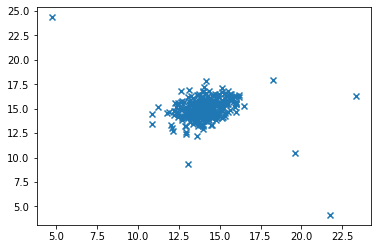

In [8]:
plt.scatter(X[:,0],X[:,1],marker="x")
plt.show()

## Visualize with probabilities

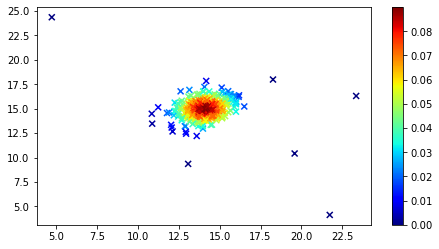

In [9]:
plt.figure(figsize=(7.5,4))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='jet')
plt.colorbar()
plt.show()

# Compute outliers
## for a threshold probability epsilon = 0.02

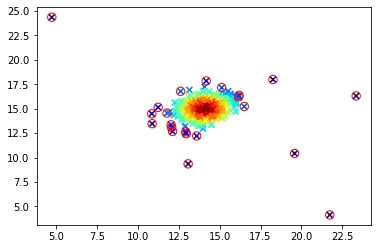

In [10]:
epsilon = 0.02

plt.figure(figsize=(6,4))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='jet')
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70)
plt.show()

# Repeat for several clusters
## using `make_blobs` function

In [15]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split

X, y_true = make_blobs(n_samples=400, centers=5, cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5, cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

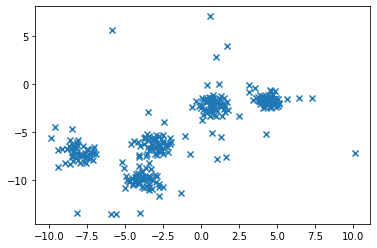

In [16]:
plt.scatter(X_train[:,0],X_train[:,1],marker="x")
plt.show()

In [25]:
mu_, sigma2_ = estimateGaussian(X_train)

[-1.83507767 -5.34263936] [18.71750414 12.12645659]


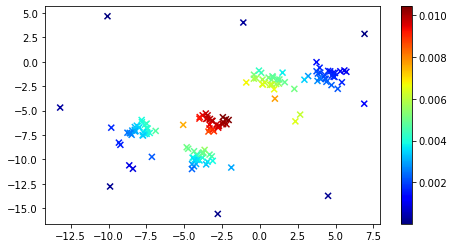

In [26]:
plt.figure(figsize=(7.5,4))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='jet')
plt.colorbar()
plt.show()

## On the train set

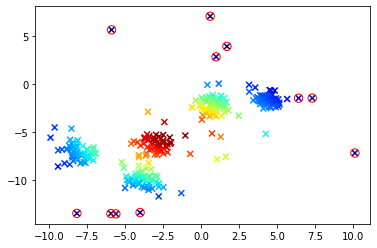

In [32]:
# We need to reduce the threshold to avoid false positives (checked visually)
##  Because probabilities are one order of magnitude lower
epsilon = 0.001

p_train = multivariateGaussian(X_train, mu_, sigma2_)

plt.figure(figsize=(6,4))
plt.scatter(X_train[:,0],X_train[:,1],marker="x",c=p_train,cmap='jet')
#plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='jet')

# Circling of anomalies
outliers = np.nonzero(p_train<epsilon)[0]

plt.scatter(X_train[outliers,0],X_train[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70)
plt.show()

# On the test set

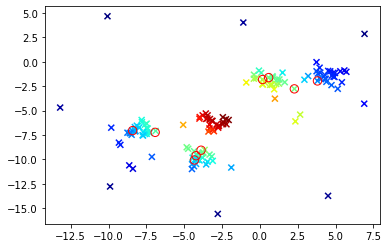

In [35]:
plt.figure(figsize=(6,4))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='jet')

p_test = multivariateGaussian(X_test, mu_, sigma2_)
# Circling of anomalies
outliers = np.nonzero(p_test<epsilon)[0]

plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70)
plt.show()

We can see that our model performed terribly on multiple clusters. It fails to recognize the outliers. That’s why now we will move to a Mixture of Gaussians.

# Mixture of Gaussians algorythm

In [37]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5, covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(n_components=5, random_state=0)

## Probability of each point being part of any of the five clusters
All other points far from every target cluster are encircled

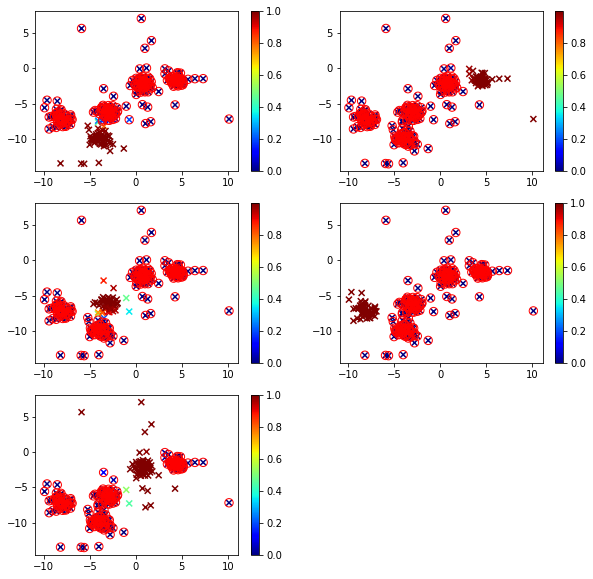

In [62]:
epsilon = 0.2

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='jet',marker='x')
    plt.colorbar()
    # Circling of anomalies
    outliers = np.nonzero(gm.predict_proba(X_train)[:,i] < epsilon)[0]
    plt.scatter(X_train[outliers,0],X_train[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70)

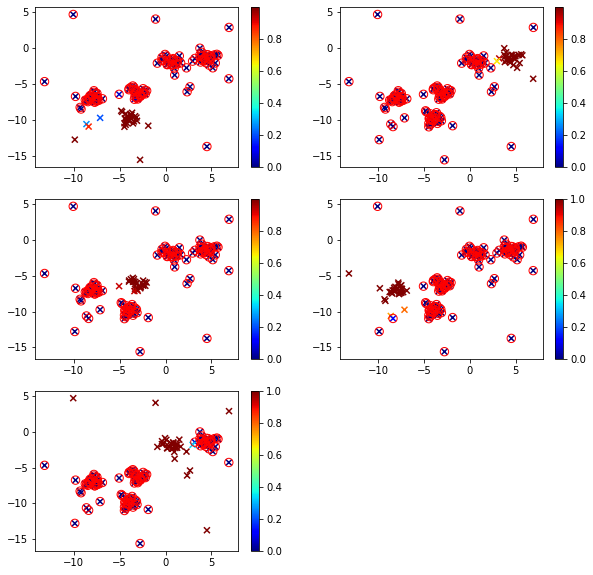

In [61]:
epsilon = 0.2

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_test[:,0],X_test[:,1],c=gm.predict_proba(X_test)[:,i],cmap='jet',marker='x')
    plt.colorbar()
    # Circling of anomalies
    outliers = np.nonzero(gm.predict_proba(X_test)[:,i] < epsilon)[0]
    plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70)